# The Battle of the Neighbourhoods - A Comparison of Neighbourhood Features in Major Financial Capitals

### Samuel Lee
### 9th October 2019
### Project github repository: https://github.com/Sam-Lee1/Coursera_Capstone
### Presentation and Report: https://ibm.box.com/s/xv895iyiwh6ptdrkisog1nnrxh1dobj4

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

This notebook works through the process of gathering data, analysing it and creating visual representations of it for the Coursera Applied Data Science Capstone Project - The Battle of the Neighbourhoods. Links to the project repository, presentation and notebook are given above.

It can be difficult to find the type of place we’re looking for when moving or travelling to new places. We will help solve this problem by analysing and presenting data about neighbourhoods in major financial capitals around the world; London, New York, Frankfurt and Toronto. Our goal is to make it easier to understand what different areas will be like, to help prioritise what areas to explore establishing a business in, moving to or visiting.

We will do this by leveraging Foursquare venue data to analyse and categorise venues in postcode areas, and use this venue data to cluster similar postcode areas and categorise them. We will need other location information, such as coordinates and post/zip codes to do this.

We will then analyse this data in various ways and create visual representations of our analysis.

## Data

## 1) Gathering post/zip code data

First we shall import all the necessary libraries, then scrape post/zip code area data from Wikipedia for neighbourhoods in Toronto, from Mapawi for neighbourhoods in Frankfurt and from Doogal for neighbourhoods in London. Then we shall upload New York neighbourhood data from the NYU spatial depository.

In [134]:
#Import libraries

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import lxml
import requests as req
import re
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as py
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [8]:
#Install packages

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [9]:
#Create web address objects

Toronto = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
London = "https://www.doogal.co.uk/london_postcodes.php"
Frankfurt = "http://zip-code.en.mapawi.com/germany/10/kreisfreie-stadt-frankfurt-am-main/2/165/frankfurt-am-main/60311/5404/"

Starting with Toronto:

In [10]:
#Scrape Toronto data from Wikipedia page

TorData = req.get(Toronto).text

#Create Beautiful Soup object

TorSp = bs(TorData, 'lxml')

In [11]:
#Extracting and cleaning rows from html

rows = TorSp.find_all('tr')
lst = []

for row in rows:
    td = row.find_all('td')             #Finding cells in each row
    cells = str(td)                     #Converting to string
    ct = bs(cells, "lxml").get_text()   #Cleaning text
    ct2 = ct.replace("[", "").replace("]", "").replace("\n", "").replace("Not assigned", "")     #Replace unwanted characters and Not assigned values
    lst.append(ct2)

In [12]:
#Converting rows to dataframe

pc = pd.DataFrame(data = lst)
pc.drop([0, 289, 290, 291, 292, 293], inplace = True)        #Dropping unwanted rows
pc2 = pc[0].str.split(',', expand = True)         #Splitting data
pc2.rename(columns = {0 : "PostCode", 1 : "Borough", 2 : "Neighbourhood"}, inplace = True)         #Renaming columns
pc3 = pc2[["PostCode", "Borough" , "Neighbourhood"]]             #Dropping unwanted columns

In [13]:
#Cleaning the Toronto Dataframe

pc4 = pc3.groupby(['PostCode', 'Borough'], as_index=False, sort=False).agg(', '.join)  #Grouping the Postcodes
pi = pc4[pc4.Borough != ' '].index  #Dropping Not Assigned Boroughs
pc5 = pc4.loc[pi, :]
pc5.loc[pc5.Neighbourhood == ' ', 'Neighbourhood'] = pc5.Borough  #Setting Not Assigned Neigbourhoods to Boroughs
pc5.reset_index(drop = True, inplace = True)  #Resetting index

In [14]:
pc5.head()

PostCode            Borough                       Neighbourhood
0      M3A         North York                           Parkwoods
1      M4A         North York                    Victoria Village
2      M5A   Downtown Toronto          Harbourfront,  Regent Park
3      M6A         North York   Lawrence Heights,  Lawrence Manor
4      M7A       Queen's Park                        Queen's Park

And now Frankfurt, referring to their zip codes as post codes for consistency:

In [15]:
#Scrape Frankfurt data from Mapawi page

FraData = req.get(Frankfurt).text

#Create Beautiful Soup object

FraSp = bs(FraData, 'lxml')

In [16]:
#Extracting and cleaning rows from html

FraZip = FraSp.find('font', class_='data').get_text()

In [17]:
#Reformat to list

FraSpl = FraZip.replace(",", "").split()

In [18]:
#Push Frankfurt Zip codes to Dataframe

FraDf = pd.DataFrame(data = FraSpl)
FraDf.rename(columns = {0 : "PostCode"}, inplace = True)

In [19]:
FraDf.head()

PostCode
0    60311
1    60313
2    60314
3    60316
4    60318

London:

In [20]:
#Scrape London data from Wikipedia page

LonData = req.get(London).text

#Create Beautiful Soup object

LonSp = bs(LonData, 'lxml')

In [21]:
#Processing postcode data to text

Lrows2 = LonSp.find('div', class_='realContent')    #Table element

Lrows3 = Lrows2.find_all('a')    #Designation of postcode (and other) elements

Lrows4 = str(Lrows3)    #Converting data to string

Lrows5 = bs(Lrows4, "lxml").get_text().replace(":", "")     #Cleaning string

In [22]:
#Using regular expressions to extract postcodes

re1 = re.compile(r'\b[A-Z]\d\b')         #Compiling regular expressions for each London postcode format
re2 = re.compile(r'\b[A-Z][A-Z]\d\b')
re3 = re.compile(r'\b[A-Z][A-Z]\d\d\b')
re4 = re.compile(r'\b[A-Z]\d\d\b')
re5 = re.compile(r'\b[A-Z][A-Z]\d[A-Z]\b')

PC1 = re1.findall(Lrows5)      #Finding values matching regex
PC2 = re2.findall(Lrows5)
PC3 = re3.findall(Lrows5)
PC4 = re4.findall(Lrows5)
PC5 = re5.findall(Lrows5)

PC = PC1 + PC2 + PC3 + PC4 + PC5   #Recombining postcodes to single list

In [23]:
#Pushing list to dataframe

LonDf = pd.DataFrame(data = PC)
LonDf.rename(columns = {0 : "PostCode"}, inplace = True)

In [24]:
LonDf.head()

PostCode
0       E1
1       E2
2       E3
3       E4
4       E5

And finally, New York, which already has coordinate data in the data set:

In [25]:
#Get data set

!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

In [26]:
#Load data

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [27]:
#The Data we need is in the features section

NYData = newyork_data['features']

In [28]:
#Define the dataframe columns and initiate dataframe
cnames = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

NYDf = pd.DataFrame(columns=cnames)

In [29]:
#Loop through dataset and add data to our dataframe

for data in NYData:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NYDf = NYDf.append({'Borough': borough,
                        'Neighbourhood': neighborhood_name,
                        'Latitude': neighborhood_lat,
                        'Longitude': neighborhood_lon},
                        ignore_index = True)

In [30]:
NYDf.head()

Borough Neighbourhood   Latitude  Longitude
0   Bronx     Wakefield  40.894705 -73.847201
1   Bronx    Co-op City  40.874294 -73.829939
2   Bronx   Eastchester  40.887556 -73.827806
3   Bronx     Fieldston  40.895437 -73.905643
4   Bronx     Riverdale  40.890834 -73.912585

## 2) Fetching coordinates for each post/zip code

Now we shall use our post/zip code data to get coordinates for each neighbourhood, importing from a csv file of geocode data for Toronto, using the python geocoders package for London and Frankfurt. Where we need neighbourhood or post/zip code data we shall also use the python geocoders package to extract that data. Once we have fetched and amalgamated all of our coordinate, neighbourhood and post/zip code data we shall visually represent our entire dataset as a navigable, labelled map:

Starting with Toronto:

In [31]:
#Create csv file object

csv = "https://cocl.us/Geospatial_data"

In [32]:
#Read data to dataframe

ll = pd.read_csv(csv)
ll.rename(columns = {"Postal Code" : "PostCode"}, inplace = True)    #Renaming column to match

In [33]:
#Merging latitude and longitude data with Canadian postcode dataframe

TorDf = pc5.merge(right = ll)

In [34]:
TorDf.head()

PostCode            Borough                       Neighbourhood   Latitude  \
0      M3A         North York                           Parkwoods  43.753259   
1      M4A         North York                    Victoria Village  43.725882   
2      M5A   Downtown Toronto          Harbourfront,  Regent Park  43.654260   
3      M6A         North York   Lawrence Heights,  Lawrence Manor  43.718518   
4      M7A       Queen's Park                        Queen's Park  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

And Frankfurt:

In [35]:
#Set Nominatim user agent and rate limiter for geopy

geolocator = Nominatim(user_agent = "neighbourhood_exploration")

geocode = RateLimiter(geolocator.geocode, max_retries = 3, min_delay_seconds = 5)

In [68]:
#Iterate through each Frankfurt zip code, getting it's coordinates and appending them to lists

#Initialise variables and lists
i = 0
FraLat = []
FraLon = []

while i < FraDf.shape[0]:   #Iterate through Dataframe
    
    g = geolocator.geocode('{}, Frankfurt, Germany'.format(FraDf.at[i, "PostCode"]), timeout = 20)    #Grab coordinates
    FraLat.append(g.latitude)      #And append
    FraLon.append(g.longitude)
    i = i + 1    #Move to next row

In [69]:
#Add our lists to our Frankfurt dataframe

FraDf["Latitude"] = FraLat
FraDf["Longitude"] = FraLon

In [70]:
#Clear out duplicate coordinate values

FraDf2 = FraDf.drop_duplicates(subset = "Longitude", keep = "first")
FraDf3 = FraDf2.reset_index(drop = True)

In [71]:
FraDf3.head()

PostCode   Latitude  Longitude
0    60311  50.110068   8.683168
1    60313  50.115699   8.683169
2    60314  50.116685   8.733465
3    60316  50.110644   8.682092
4    60323  50.123805   8.660706

In [72]:
#Iterate through each Frankfurt coordinates, grabbing neighbourhoods and appending them to a list

#Initialise regex, variables and lists
reFra = re.compile(r'(?:.*, )(.*)(?:, Frankfurt)')
i = 0
FraNei = []
Test = []

while i < FraDf3.shape[0]:   #Iterate through Dataframe
   
    q = FraDf3.at[i, "Latitude"], FraDf3.at[i, "Longitude"]    #Set coordinates
    qc = geolocator.reverse(q, timeout = 20)    #Grab address
    qs = str(qc)             #Convert to string
    qf = reFra.findall(qs)    #Extract neighbourhood
    Test.append(qs)
    FraNei.extend(qf)      #And append
    i = i + 1    #Move to next row

In [73]:
#Add neighbourhod column to the dataframe

FraDf3["Neighbourhood"] = FraNei

In [74]:
#Move Neighbourhood column to second

cols = ["PostCode", "Neighbourhood", "Latitude", "Longitude"]
FraDf3 = FraDf3[cols]

In [75]:
FraDf3.head()

PostCode Neighbourhood   Latitude  Longitude
0    60311      Altstadt  50.110068   8.683168
1    60313    Innenstadt  50.115699   8.683169
2    60314        Ostend  50.116685   8.733465
3    60316      Altstadt  50.110644   8.682092
4    60323  Westend Nord  50.123805   8.660706

And London:

Note: The following 4 code cells have been commented out since they were used over multiple sessions to push the queried London coordinate data to a csv file

In [44]:
#Iterate through each London post code, getting it's coordinates and appending them to lists

#Initialise variables and lists
#j = 0
#LonLat = []
#LonLon = []
#LonPC = []

#while j < LonDf.shape[0]:   #Iterate through Dataframe
    
#    try:
#        h = geolocator.geocode('{}, London , England'.format(LonDf.at[j, "PostCode"]), timeout = 20)    #Grab coordinates
#        LonLat.append(h.latitude)      #And append
#        LonLon.append(h.longitude)
#        LonPC.append(LonDf.at[j, "PostCode"])
#        j = j + 1    #Move to next row
    
#    except AttributeError as exception:       #Error handling
#        continue

In [45]:
#LonZip = list(zip(LonPC, LonLat, LonLon))

In [46]:
#LonCD = pd.DataFrame(data = LonZip, columns = ["PostCode", "Latitude", "Longitude"])

Due to our London postcodes generating too many requests to geopy, we have processed the data in subsets across multiple sessions, and pushed the results to a csv, hosted on github

In [47]:
#LonCD.to_csv(header = False)

Reuploading the complete London coordinate csv:

In [48]:
Loncsv = "https://raw.githubusercontent.com/Sam-Lee1/Coursera_Capstone/master/LonCoord.csv"

In [49]:
#Read csv to dataframe

LonDf2 = pd.read_csv(Loncsv)

In [50]:
LonDf2.head()

PostCode   Latitude  Longitude
0       E1  51.517078  -0.055237
1       E2  51.528886  -0.062453
2       E3  51.527507  -0.023339
3       E4  51.632758  -0.006313
4       E5  51.559155  -0.052794

And for Londons neighbourhoods:

In [51]:
#Iterate through each London coordinates, getting their neighbourhoods and appending them to a list

#Initialise regex, variables and lists
reLon = re.compile(r'(?:.*, )(.*)(?:,.*,)(?: London)')
reLon2 = re.compile(r"(.*)(?:,.*)(?:, London)")

j = 0
LonNei = []

while j < LonDf2.shape[0]:   #Iterate through Dataframe
   
    u = LonDf2.at[j, "Latitude"], LonDf2.at[j, "Longitude"]    #Set coordinates
    uc = geolocator.reverse(u, timeout = 20)    #Grab address
    us = str(uc)             #Convert to string
    uf = reLon.findall(us)    #Extract neighbourhood
    
    if len(uf) == 0:
        uf = reLon2.findall(us)     #Secondary regex for missing neighbourhoods
        
        if len(uf) == 0:
            uf = ["Covent Garden"]     #Manual input of final erroring neighbourhood
            
    LonNei.extend(uf)      #And append
    j = j + 1    #Move to next row

In [52]:
#Add neighbourhood columns to the dataframe

LonDf2["Neighbourhood"] = LonNei

In [53]:
#Move Neighbourhood column to second

cols = ["PostCode", "Neighbourhood", "Latitude", "Longitude"]
LonDf2 = LonDf2[cols]

In [54]:
LonDf2.head()

PostCode  Neighbourhood   Latitude  Longitude
0       E1       Shadwell  51.517078  -0.055237
1       E2  Bethnal Green  51.528886  -0.062453
2       E3            Bow  51.527507  -0.023339
3       E4      Chingford  51.632758  -0.006313
4       E5  Lower Clapton  51.559155  -0.052794

For New York we already have coordinate and neighbourhood data, so we shall pull zip codes for each neighbourhood, tabling them as post codes for consistency:

In [55]:
#Iterate through the New York coordinates, grabbing each zip code and appending them to a list

#Initialise regex, variables and lists
reNY = re.compile(r'\b\d{5}\b')
k = 0
NYZip = []
Test = []

while k < NYDf.shape[0]:   #Iterate through Dataframe
   
    l = NYDf.at[k, "Latitude"], NYDf.at[k, "Longitude"]    #Set coordinates
    lc = geolocator.reverse(l, timeout = 20)    #Grab address
    ls = str(lc)             #Convert to string
    lf = reNY.findall(ls)    #Extract Zip Code
    Test.append(ls)
    NYZip.extend(lf)      #And append
    k = k + 1    #Move to next row

In [56]:
#Add zip codes to dataframe

NYDf["PostCode"] = NYZip

In [57]:
#Move PostCode column to the front

cols = list(NYDf.columns)
cols = [cols[-1]] + cols[:-1]
NYDf = NYDf[cols]

In [58]:
NYDf.head()

PostCode Borough Neighbourhood   Latitude  Longitude
0    10466   Bronx     Wakefield  40.894705 -73.847201
1    10475   Bronx    Co-op City  40.874294 -73.829939
2    10466   Bronx   Eastchester  40.887556 -73.827806
3    10471   Bronx     Fieldston  40.895437 -73.905643
4    10463   Bronx     Riverdale  40.890834 -73.912585

We shall now amalgamate our dataframes to create an inter-city neighbourhood dataframe:

In [76]:
#Drop borough columns for consistency

TorDf2 = TorDf.drop("Borough", axis = 1)
NYDf2 = NYDf.drop("Borough", axis = 1)

In [77]:
#Create inter-city dataframe

DfList = [FraDf3, LonDf2, NYDf2] #Create list of Dataframes

IntDf = TorDf2.append(DfList, ignore_index = True, sort = False) #Create dataframe

In [78]:
IntDf.shape

(583, 4)

So we have 583 total neighbourhoods across four international cities to analyse. Prior to analysis we shall represent our total inter-city data set as a navigable, labelled map:

In [59]:
#Set London's coordinates to centre the map on

LLat = 51.5194
LLong = -0.0927

In [60]:
#Create navigable map, labelled with neighbourhoods and post/zip codes, centered on London

NLmap = folium.Map(location=[LLat, LLong], zoom_start=11)

#Add markers to the map
for lat, lon, label in zip(IntDf['Latitude'], IntDf['Longitude'], "Neighbourhood: " + IntDf['Neighbourhood'] + ", Post/Zip Code: " + IntDf['PostCode']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7).add_to(NLmap)

In [61]:
NLmap

## Methodology <a name="methodology"></a>

## 3) Fetching nearby venue data from Foursquare

Next we shall use our coordinate data to fetch nearby venue data for each neighbourhood in all the cities, then to one hot encode it and establish the relative frequency of venue category for each neighbourhood.

Foursquare credentials imported below, cell removed for security.

In [64]:
{
    "tags": [
            "remove_input",
        ]
}

#Importing Foursquare credentials (have since been reset)

CLIENT_ID = 'JIGNDYJU5UYTDOZQMOKXHXZINYDD4OTC0CCHKDXV21OXPYA4' # Foursquare ID
CLIENT_SECRET = 'PFQDDZY3AX5L34PHY4RQVELPWSBOCIXXP1IMWTVZJ0QHGHKJ' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [65]:
#Defining function to get nearby venues

def getNearbyVenues(names, areas, latitudes, longitudes, radius = 500, limit = 100):
    
    venues_list=[]
    for name, area, lat, lng in zip(names, areas, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = req.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            area,
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostCode', 
                  'Neighbourhood',
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Starting with Toronto:

In [66]:
#Fetching Toronto neighbourhood venues

TorVen = getNearbyVenues(names = TorDf['PostCode'],
                         areas = TorDf['Neighbourhood'],
                         latitudes = TorDf['Latitude'],
                         longitudes = TorDf['Longitude']
                                  )

In [67]:
#One hot encoding venues

Tor1h = pd.get_dummies(TorVen[['Venue Category']], prefix="", prefix_sep="")

#Add and move PostCode and Neighbourhood columna
Tor1h['PostCode'] = TorVen['PostCode']
Tor1h['Neighbourhood'] = TorVen['Neighbourhood']
fixed_columns = [Tor1h.columns[-2]] + [Tor1h.columns[-1]] + list(Tor1h.columns[:-2])
Tor1h = Tor1h[fixed_columns]

In [68]:
Tor1h.head()

PostCode      Neighbourhood  Accessories Store  Afghan Restaurant  Airport  \
0      M3A          Parkwoods                  0                  0        0   
1      M3A          Parkwoods                  0                  0        0   
2      M4A   Victoria Village                  0                  0        0   
3      M4A   Victoria Village                  0                  0        0   
4      M4A   Victoria Village                  0                  0        0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  ...  Turkish Restaurant  \
0                    0  ...                   0   
1                    0  ...                   0   
2                    0  ...                   0   
3                    0  ...                   0   
4                    0  ...                   0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 0            0   
1                              0                 0            0   
2                              0                 0            0   
3                              0                 0            0   
4                              0                 0            0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
0                      0                0         0            0   
1                      0                0         0            0   
2                      0                0         0            0   
3                      0                0         0            0   
4                      0                0         0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 274 columns]

In [69]:
#Finding the mean of category occurence in each neighbourhood

TorM = Tor1h.groupby(['PostCode', 'Neighbourhood']).mean().reset_index()

In [70]:
#Define function to sort neigbourhoods by most common venues

def common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [71]:
#Create dataframe of top ten venues for each Toronto neighbourhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#Create columns according to number of top venues
columns = ['PostCode', "Neighbourhood"]
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create the new dataframe
TorR = pd.DataFrame(columns=columns)
TorR['PostCode'] = TorM['PostCode']
TorR['Neighbourhood'] = TorM['Neighbourhood']

for ind in np.arange(TorM.shape[0]):
    TorR.iloc[ind, 2:] = common_venues(TorM.iloc[ind, :], num_top_venues)

In [72]:
TorR.head()

PostCode                              Neighbourhood 1st Most Common Venue  \
0      M1B                            Rouge,  Malvern            Print Shop   
1      M1C   Highland Creek,  Rouge Hill,  Port Union                   Bar   
2      M1E        Guildwood,  Morningside,  West Hill        Breakfast Spot   
3      M1G                                     Woburn           Coffee Shop   
4      M1H                                  Cedarbrae                Bakery   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0  Fast Food Restaurant  Ethiopian Restaurant            Donut Shop   
1           Yoga Studio  Ethiopian Restaurant             Drugstore   
2        Medical Center   Rental Car Location     Electronics Store   
3     Korean Restaurant  Ethiopian Restaurant             Drugstore   
4   Fried Chicken Joint  Caribbean Restaurant      Hakka Restaurant   

  5th Most Common Venue        6th Most Common Venue  \
0             Drugstore          Dumpling Restaurant   
1   Dumpling Restaurant  Eastern European Restaurant   
2    Mexican Restaurant                 Intersection   
3   Dumpling Restaurant  Eastern European Restaurant   
4    Athletics & Sports              Thai Restaurant   

         7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0  Eastern European Restaurant     Electronics Store   Empanada Restaurant   
1            Electronics Store   Empanada Restaurant           Event Space   
2                  Pizza Place    Falafel Restaurant           Event Space   
3            Electronics Store   Empanada Restaurant           Yoga Studio   
4                         Bank            Donut Shop             Drugstore   

  10th Most Common Venue  
0            Yoga Studio  
1            Fish Market  
2   Ethiopian Restaurant  
3       Doner Restaurant  
4    Dumpling Restaurant

And now Frankfurt:

In [73]:
#Fetching Frankfurt neighbourhood venues

FraVen = getNearbyVenues(names = FraDf3['PostCode'],
                         areas = FraDf3['Neighbourhood'],
                         latitudes = FraDf3['Latitude'],
                         longitudes = FraDf3['Longitude']
                                  )

In [74]:
#One hot encoding venues

Fra1h = pd.get_dummies(FraVen[['Venue Category']], prefix="", prefix_sep="")

#Add and move PostCode column
Fra1h['PostCode'] = FraVen['PostCode']
Fra1h['Neighbourhood'] = FraVen['Neighbourhood']
fixed_columns = [Fra1h.columns[-2]] + [Fra1h.columns[-1]] + list(Fra1h.columns[:-2])
Fra1h = Fra1h[fixed_columns]

In [75]:
#Finding the mean of category occurence in each neighbourhood

FraM = Fra1h.groupby(['PostCode', 'Neighbourhood']).mean().reset_index()

In [76]:
#Create dataframe of top ten venues for each Frankfurt neighbourhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#Create columns according to number of top venues
columns = ['PostCode', 'Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create the new dataframe
FraR = pd.DataFrame(columns=columns)
FraR['PostCode'] = FraM['PostCode']
FraR['Neighbourhood'] = FraM['Neighbourhood']

for ind in np.arange(FraM.shape[0]):
    FraR.iloc[ind, 2:] = common_venues(FraM.iloc[ind, :], num_top_venues)

In [77]:
FraR.head()

PostCode Neighbourhood   1st Most Common Venue 2nd Most Common Venue  \
0    60311      Altstadt                    Café     German Restaurant   
1    60313    Innenstadt      Italian Restaurant            Restaurant   
2    60314        Ostend  Furniture / Home Store           IT Services   
3    60316      Altstadt                    Café                 Plaza   
4    60323  Westend Nord      Italian Restaurant      Botanical Garden   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Art Museum          Burger Joint                 Plaza   
1                 Hotel       Thai Restaurant                  Café   
2       Motorcycle Shop           Pizza Place      Currywurst Joint   
3            Restaurant           Coffee Shop     German Restaurant   
4                  Park      Asian Restaurant                  Café   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Restaurant          Cocktail Bar                   Pub   
1           Coffee Shop                 Plaza      Department Store   
2   Sporting Goods Shop   Fried Chicken Joint     Food & Drink Shop   
3          Burger Joint            Art Museum                   Bar   
4                Garden           Coffee Shop                   Bar   

  9th Most Common Venue 10th Most Common Venue  
0        Scenic Lookout                 Bistro  
1             Nightclub            Men's Store  
2      Department Store         Chocolate Shop  
3                Bistro         Scenic Lookout  
4    Spanish Restaurant      German Restaurant

And now for London:

In [79]:
#Fetching London neighbourhood venues

LonVen = getNearbyVenues(names = LonDf2['PostCode'],
                         areas = LonDf2['Neighbourhood'],
                         latitudes = LonDf2['Latitude'],
                         longitudes = LonDf2['Longitude']
                                  )

In [80]:
#One hot encoding venues

Lon1h = pd.get_dummies(LonVen[['Venue Category']], prefix="", prefix_sep="")

#Add and move PostCode and Neighbourhood columns
Lon1h['PostCode'] = LonVen['PostCode']
Lon1h['Neighbourhood'] = LonVen['Neighbourhood']
fixed_columns = [Lon1h.columns[-2]] + [Lon1h.columns[-1]] + list(Lon1h.columns[:-2])
Lon1h = Lon1h[fixed_columns]

In [81]:
#Finding the mean of category occurence in each neighbourhood

LonM = Lon1h.groupby(['PostCode', 'Neighbourhood']).mean().reset_index()

In [82]:
#Create dataframe of top ten venues for each London neighbourhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#Create columns according to number of top venues
columns = ['PostCode', 'Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create the new dataframe
LonR = pd.DataFrame(columns=columns)
LonR['PostCode'] = LonM['PostCode']
LonR['Neighbourhood'] = LonM['Neighbourhood']

for ind in np.arange(LonM.shape[0]):
    LonR.iloc[ind, 2:] = common_venues(LonM.iloc[ind, :], num_top_venues)

In [83]:
LonR.head()

PostCode  Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0       E1       Shadwell                   Pub         Grocery Store   
1      E10         Leyton         Grocery Store     Convenience Store   
2      E11       Wanstead                  Park              Bus Stop   
3      E12  Little Ilford           Gas Station  Gym / Fitness Center   
4      E13       Plaistow                   Pub           Bus Station   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0     Indian Restaurant          Burger Joint        Sandwich Place   
1          Betting Shop             BBQ Joint                  Park   
2            Restaurant   Filipino Restaurant  Ethiopian Restaurant   
3            Restaurant           Auto Garage        Farmers Market   
4                  Café                   Gym     Convenience Store   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   Gym / Fitness Center           Coffee Shop                 Hotel   
1    Fried Chicken Joint    Chinese Restaurant                 Hotel   
2            Event Space               Exhibit           Fabric Shop   
3  Entertainment Service  Ethiopian Restaurant           Event Space   
4   Fast Food Restaurant  Ethiopian Restaurant           Event Space   

  9th Most Common Venue 10th Most Common Venue  
0    Chinese Restaurant                   Park  
1        Cricket Ground            Flea Market  
2    Falafel Restaurant                   Farm  
3               Exhibit            Fabric Shop  
4               Exhibit            Fabric Shop

And next, New York:

In [87]:
#Fetching New York neighbourhood venues

NYVen = getNearbyVenues(names = NYDf['PostCode'],
                         areas = NYDf['Neighbourhood'],
                         latitudes = NYDf['Latitude'],
                         longitudes = NYDf['Longitude']
                                  )

In [88]:
#One hot encoding venues

NY1h = pd.get_dummies(NYVen[['Venue Category']], prefix="", prefix_sep="")

#Add and move PostCode and Neighbourhood columns
NY1h['PostCode'] = NYVen['PostCode']
NY1h['Neighbourhood'] = NYVen['Neighbourhood']
fixed_columns = [NY1h.columns[-2]] + [NY1h.columns[-1]] + list(NY1h.columns[:-2])
NY1h = NY1h[fixed_columns]

In [89]:
#Finding the mean of category occurence in each neighbourhood

NYM = NY1h.groupby(['PostCode', 'Neighbourhood']).mean().reset_index()

In [90]:
#Create dataframe of top ten venues for each New York neighbourhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#Create columns according to number of top venues
columns = ['PostCode', 'Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create the new dataframe
NYR = pd.DataFrame(columns=columns)
NYR['PostCode'] = NYM['PostCode']
NYR['Neighbourhood'] = NYM['Neighbourhood']

for ind in np.arange(NYM.shape[0]):
    NYR.iloc[ind, 2:] = common_venues(NYM.iloc[ind, :], num_top_venues)

In [91]:
NYR.head()

PostCode       Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0    10002           Chinatown    Chinese Restaurant          Cocktail Bar   
1    10002     Lower East Side           Pizza Place                  Café   
2    10003                Noho    Italian Restaurant           Art Gallery   
3    10005  Financial District           Coffee Shop            Food Truck   
4    10009        East Village                   Bar        Ice Cream Shop   

  3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0   American Restaurant                Bakery  Vietnamese Restaurant   
1    Chinese Restaurant           Coffee Shop                   Park   
2          Cocktail Bar     French Restaurant            Coffee Shop   
3             Wine Shop           Pizza Place                    Gym   
4              Wine Bar    Chinese Restaurant            Pizza Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0       Bubble Tea Shop                   Spa    Salon / Barbershop   
1                Bakery           Art Gallery   Japanese Restaurant   
2             Rock Club           Pizza Place             Bookstore   
3          Cocktail Bar  Gym / Fitness Center            Steakhouse   
4    Mexican Restaurant          Cocktail Bar      Ramen Restaurant   

           9th Most Common Venue 10th Most Common Venue  
0                   Optical Shop      Hotpot Restaurant  
1                 Sandwich Place       Ramen Restaurant  
2                       Boutique     Mexican Restaurant  
3                          Hotel            Event Space  
4  Vegetarian / Vegan Restaurant            Coffee Shop

And lastly, to amalgamate these tables for inter-city data:

In [92]:
#Create combined top ten most common venue table for inter-city data

RList = [FraR, LonR, NYR] #Create list of Dataframes

IntR = TorR.append(RList, ignore_index = True, sort = False)

## Analysis <a name="analysis"></a>

## 4) Performing K-means clustering analysis

We shall perform K means clustering on the inter-city dataset; first we shall use the elbow curve method to choose the optimum number of clusters, then we shall examine and label our clusters for that optimum number:

In [93]:
#Create combined mean category occurence table for inter-city clustering

MList = [FraM, LonM, NYM] #Create list of Dataframes

IntM = TorM.append(MList, ignore_index = True, sort = False)
IntM = IntM.fillna(0)

In [94]:
IntM.head()

PostCode                              Neighbourhood  Accessories Store  \
0      M1B                            Rouge,  Malvern                0.0   
1      M1C   Highland Creek,  Rouge Hill,  Port Union                0.0   
2      M1E        Guildwood,  Morningside,  West Hill                0.0   
3      M1G                                     Woburn                0.0   
4      M1H                                  Cedarbrae                0.0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Lounge  \
0                0.0      0.0                 0.0             0.0   
1                0.0      0.0                 0.0             0.0   
2                0.0      0.0                 0.0             0.0   
3                0.0      0.0                 0.0             0.0   
4                0.0      0.0                 0.0             0.0   

   Airport Service  Airport Terminal  American Restaurant  ...  \
0              0.0               0.0                  0.0  ...   
1              0.0               0.0                  0.0  ...   
2              0.0               0.0                  0.0  ...   
3              0.0               0.0                  0.0  ...   
4              0.0               0.0                  0.0  ...   

   Tibetan Restaurant  Toll Plaza  Track  Train  Tree  Varenyky restaurant  \
0                 0.0         0.0    0.0    0.0   0.0                  0.0   
1                 0.0         0.0    0.0    0.0   0.0                  0.0   
2                 0.0         0.0    0.0    0.0   0.0                  0.0   
3                 0.0         0.0    0.0    0.0   0.0                  0.0   
4                 0.0         0.0    0.0    0.0   0.0                  0.0   

   Venezuelan Restaurant  Volleyball Court  Waste Facility  Weight Loss Center  
0                    0.0               0.0             0.0                 0.0  
1                    0.0               0.0             0.0                 0.0  
2                    0.0               0.0             0.0                 0.0  
3                    0.0               0.0             0.0                 0.0  
4                    0.0               0.0             0.0                 0.0  

[5 rows x 507 columns]

In [95]:
#Reformat mean category occurence tables for clustering, drop non value columns

TorN = TorM.drop(['PostCode', 'Neighbourhood'], 1)
FraN = FraM.drop(['PostCode', 'Neighbourhood'], 1)
LonN = LonM.drop(['PostCode', 'Neighbourhood'], 1)
NYN = NYM.drop(['PostCode', 'Neighbourhood'], 1)
IntN = IntM.drop(['PostCode', 'Neighbourhood'], 1)

In [90]:
#Performing K means clustering for 1 - 15 clusters and scoring cluster variance

Nc = range(1, 15)

kmeans = [KMeans(n_clusters = i) for i in Nc]

#Using the score method to establish the percentage of variance accounted for by the numer of clusters

score = [kmeans[i].fit(IntN).score(IntN) for i in range(len(kmeans))]

score

[-64.90220124537237,
 -60.115078846977724,
 -58.10575797228839,
 -56.03741322473622,
 -54.892355670158395,
 -53.66695863437033,
 -52.48291141825259,
 -52.146263836241815,
 -51.17071108525604,
 -50.5060077754006,
 -49.53382130241038,
 -48.57713162985726,
 -47.643268654078746,
 -47.04430634762114]

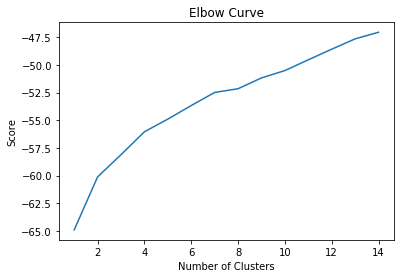

In [91]:
#Plotting the elbow curve

py.plot(Nc, score)

py.xlabel('Number of Clusters')
py.ylabel('Score')
py.title('Elbow Curve')

py.show()

Our clusters don't tend towards a limit of marginal improvement given our range and use of more clusters wouldn't be practical. Theres something of a reduction in marginal improvement at 7 clusters and that's a practical number for representing our data, so we shall use 7 clusters:

In [51]:
#Set number of clusters

kclusters = 7

In [97]:
#Run inter-city k-means clustering

kmeansInt = KMeans(n_clusters = kclusters, random_state = 15).fit(IntN)

In [104]:
#Cell used to drop old cluster labels if rerunning clustering

#IntR.drop("Cluster Labels", axis = 1, inplace = True)

In [99]:
#Add clustering labels

IntR.insert(2, 'Cluster Labels', kmeansInt.labels_)

In [100]:
#Reformat tables for merge

IntR2 = IntR.drop('Neighbourhood', 1)

#Merge toronto data with toronto cluster data
IntCl = IntDf.join(IntR2.set_index('PostCode'), on = 'PostCode', how = 'left')

#Drop neighbourhoods missing venue data and duplicate neighbourhoods
IntCl.dropna(axis = 0, how = "any", inplace = True)

IntCl.drop_duplicates("Latitude", inplace = True)

In [103]:
#Examining the size of our clusters

nCl = range(0, 7)

for i in nCl:
    Cl = IntCl.loc[IntCl['Cluster Labels'] == i, IntCl.columns[[1] + [4] + list(range(5, IntCl.shape[1]))]]
    print(Cl.shape)

(24, 12)
(149, 12)
(242, 12)
(62, 12)
(13, 12)
(1, 12)
(87, 12)


In [105]:
IntCl.head()

PostCode                       Neighbourhood   Latitude  Longitude  \
0      M3A                           Parkwoods  43.753259 -79.329656   
1      M4A                    Victoria Village  43.725882 -79.315572   
2      M5A          Harbourfront,  Regent Park  43.654260 -79.360636   
3      M6A   Lawrence Heights,  Lawrence Manor  43.718518 -79.464763   
4      M7A                        Queen's Park  43.662301 -79.389494   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0             4.0                  Park     Food & Drink Shop   
1             3.0          Intersection           Pizza Place   
2             1.0           Coffee Shop                  Café   
3             2.0        Clothing Store     Accessories Store   
4             1.0           Coffee Shop                   Gym   

  3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0           Yoga Studio   Empanada Restaurant             Donut Shop   
1          Hockey Arena     French Restaurant  Portuguese Restaurant   
2                   Pub                Bakery                   Park   
3           Coffee Shop   Sporting Goods Shop       Fraternity House   
4                 Diner                  Park     Seafood Restaurant   

  6th Most Common Venue   7th Most Common Venue        8th Most Common Venue  \
0             Drugstore     Dumpling Restaurant  Eastern European Restaurant   
1           Coffee Shop       Electronics Store             Doner Restaurant   
2            Restaurant    Gym / Fitness Center               Breakfast Spot   
3    Miscellaneous Shop  Furniture / Home Store                     Boutique   
4          Burger Joint           Burrito Place               Sandwich Place   

  9th Most Common Venue 10th Most Common Venue  
0     Electronics Store            Event Space  
1            Donut Shop              Drugstore  
2               Theater     Mexican Restaurant  
3         Women's Store  Vietnamese Restaurant  
4                  Café             Restaurant

Exporting to CSV such that maps can be created without rerunning entire notebook:

In [138]:
#Create csv object

ICL = IntCl.to_csv()

In [172]:
#Replace problem characters

exportICL = ICL.replace("é", "e")

In [ ]:
#Return csv as string

exportICL

And re-importing the CSV:

In [86]:
#Create address object for inter-city data set csv

ImportICl = "https://raw.githubusercontent.com/Sam-Lee1/Coursera_Capstone/master/IntCl.txt"

In [87]:
#Read and format csv

IntCl = pd.read_csv(ImportICl)
IntCl.drop(columns = "'", inplace = True)
IntCl.drop([578], inplace = True)

In [88]:
IntCl

PostCode                                      Neighbourhood   Latitude  \
0        M3A                                          Parkwoods  43.753259   
1        M4A                                   Victoria Village  43.725882   
2        M5A                         Harbourfront,  Regent Park  43.654260   
3        M6A                  Lawrence Heights,  Lawrence Manor  43.718518   
4        M7A                                      Queen\'s Park  43.662301   
5        M1B                                    Rouge,  Malvern  43.806686   
6        M3B                                    Don Mills North  43.745906   
7        M4B                   Woodbine Gardens,  Parkview Hill  43.706397   
8        M5B                          Ryerson,  Garden District  43.657162   
9        M6B                                          Glencairn  43.709577   
10       M9B   Cloverdale,  Islington,  Martin Grove,  Princ...  43.650943   
11       M1C           Highland Creek,  Rouge Hill,  Port Union  43.784535   
12       M3C                  Flemingdon Park,  Don Mills South  43.725900   
13       M4C                                   Woodbine Heights  43.695344   
14       M5C                                     St. James Town  43.651494   
15       M6C                                 Humewood-Cedarvale  43.693781   
16       M9C   Bloordale Gardens,  Eringate,  Markland Wood,...  43.643515   
17       M1E                Guildwood,  Morningside,  West Hill  43.763573   
18       M4E                                        The Beaches  43.676357   
19       M5E                                        Berczy Park  43.644771   
20       M6E                                Caledonia-Fairbanks  43.689026   
21       M1G                                             Woburn  43.770992   
22       M4G                                            Leaside  43.709060   
23       M5G                                 Central Bay Street  43.657952   
24       M6G                                           Christie  43.669542   
25       M1H                                          Cedarbrae  43.773136   
26       M2H                                  Hillcrest Village  43.803762   
27       M3H   Bathurst Manor,  Downsview North,  Wilson Hei...  43.754328   
28       M4H                                   Thorncliffe Park  43.705369   
29       M5H                         Adelaide,  King,  Richmond  43.650571   
..       ...                                                ...        ...   
548    10011                                           Flatiron  40.739673   
549    11104                                  Sunnyside Gardens  40.745652   
550    11104                                         Blissville  40.737251   
551    11201                                       Fulton Ferry  40.703281   
552    11201                                       Vinegar Hill  40.703321   
553    11213                                         Weeksville  40.675040   
554    11207                                  Broadway Junction  40.677861   
555    11201                                              Dumbo  40.703176   
556    10314                                      Manor Heights  40.601810   
557    10314                                        Willowbrook  40.603707   
558    10309                                       Sandy Ground  40.541140   
559    10314                                        Egbertville  40.579119   
560    11697                                            Roxbury  40.567376   
561    11229                                          Homecrest  40.598525   
562    11379                                     Middle Village  40.716415   
563    10309                                      Prince\'s Bay  40.526264   
564    10306                                    Lighthouse Hill  40.576506   
565    10309                                    Richmond Valley  40.519541   
566    11357                                              Malba  40.790602   
567    11207              

Now to examine our clusters and choose characterising labels for them, based on the most frequent nearby venues:

In [89]:
#Examine cluster 0

IntCl.loc[IntCl['Cluster Labels'] == 0, IntCl.columns[[1] + [4] + list(range(5, IntCl.shape[1]))]]

Neighbourhood  Cluster Labels 1st Most Common Venue  \
31             Scarborough Village             0.0            Playground   
39    CFB Toronto,  Downsview East             0.0               Airport   
114                      Praunheim             0.0         Metro Station   
120                      Zeilsheim             0.0        Ice Cream Shop   
123                     Sossenheim             0.0             Nightclub   
134                       Wanstead             0.0                  Park   
226                 Ellesmere Road             0.0         Historic Site   
478                  Port Richmond             0.0              Bus Stop   
479              Mariner\'s Harbor             0.0              Bus Stop   
480                     Port Ivory             0.0              Bus Stop   
481              Castleton Corners             0.0     Recreation Center   
482                New Springville             0.0     Recreation Center   
483                         Travis             0.0     Recreation Center   
498                    Westerleigh             0.0     Recreation Center   
499                   Graniteville             0.0              Bus Stop   
500                      Arlington             0.0              Bus Stop   
516              Heartland Village             0.0     Recreation Center   
517                        Chelsea             0.0     Recreation Center   
518                     Bloomfield             0.0     Recreation Center   
519                     Bulls Head             0.0     Recreation Center   
530                       Elm Park             0.0              Bus Stop   
556                  Manor Heights             0.0     Recreation Center   
557                    Willowbrook             0.0     Recreation Center   
559                    Egbertville             0.0     Recreation Center   

    2nd Most Common Venue 3rd Most Common Venue       4th Most Common Venue  \
31    Empanada Restaurant      Doner Restaurant                  Donut Shop   
39                   Park              Bus Stop                 Yoga Studio   
114           Gas Station              Bus Stop                 Supermarket   
120           Supermarket              Bus Stop          Light Rail Station   
123              Bus Stop         Grocery Store                 Yoga Studio   
134              Bus Stop            Restaurant         Filipino Restaurant   
226              Bus Stop            Playground                        Cafe   
478         Deli / Bodega   American Restaurant                  Toll Plaza   
479          Intersection         Boat or Ferry  Construction & Landscaping   
480          Intersection         Boat or Ferry  Construction & Landscaping   
481            Theme Park        Discount Store                    Bus Stop   
482            Theme Park        Discount Store                    Bus Stop   
483            Theme Park        Discount Store                    Bus Stop   
498            Theme Park        Discount Store                    Bus Stop   
499          Intersection         Boat or Ferry  Construction & Landscaping   
500          Intersection         Boat or Ferry  Construction & Landscaping   
516            Theme Park        Discount Store                    Bus Stop   
517            Theme Park        Discount Store                    Bus Stop   
518            Theme Park        Discount Store                    Bus Stop   
519            Theme Park        Discount Store                    Bus Stop   
530         Deli / Bodega   American Restaurant                  Toll Plaza   
556            Theme Park        Discount Store                    Bus Stop   
557            Theme Park        Discount Store                    Bus Stop   
559            Theme Park        Discount Store                    Bus Stop   

    5th Most Common Venue 6th Most Common Venue        7th Most Common Venue  \
31              Drugstore   Dumpling Restaurant  Eastern Europea

Theme parks are the most frequent venue near these neighbourhoods; followed by recreation centres and parks; so we shall label this cluster Theme Parks and Recreation:

In [90]:
#Choose a label for cluster 0 based on the venues

cl0 = "Theme Parks and Recreation"

In [91]:
#Examine cluster 1

IntCl.loc[IntCl['Cluster Labels'] == 1, IntCl.columns[[1] + [4] + list(range(5, IntCl.shape[1]))]]

Neighbourhood  Cluster Labels  \
2                           Harbourfront,  Regent Park             1.0   
4                                        Queen\'s Park             1.0   
6                                      Don Mills North             1.0   
9                                            Glencairn             1.0   
18                                         The Beaches             1.0   
21                                              Woburn             1.0   
23                                  Central Bay Street             1.0   
24                                            Christie             1.0   
33                    Northwood Park,  York University             1.0   
35    Harbourfront East,  Toronto Islands,  Union S...             1.0   
37       East Birchmount Park,  Ionview,  Kennedy Park             1.0   
41           Design Exchange,  Toronto Dominion Centre             1.0   
42      Brockton,  Exhibition Place,  Parkdale Village             1.0   
47                     Commerce Court,  Victoria Hotel             1.0   
53                  Bedford Park,  Lawrence Manor East             1.0   
56                        Birch Cliff,  Cliffside West             1.0   
72               The Annex,  North Midtown,  Yorkville             1.0   
74               Canada Post Gateway Processing Centre             1.0   
78                     Harbord,  University of Toronto             1.0   
79                                 Runnymede,  Swansea             1.0   
84    Deer Park,  Forest Hill SE,  Rathnelly,  Sout...             1.0   
90                     Stn A PO Boxes 25 The Esplanade             1.0   
93                        Cabbagetown,  St. James Town             1.0   
94             First Canadian Place,  Underground city             1.0   
107                                        Nordend Ost             1.0   
116                                          Flughafen             1.0   
124                                           Shadwell             1.0   
125                                      Bethnal Green             1.0   
126                                                Bow             1.0   
127                                          Chingford             1.0   
..                                                 ...             ...   
235                                            Hanwell             1.0   
236                                    West Kensington             1.0   
238                                        Clerkenwell             1.0   
239                                            Holborn             1.0   
240                                        Clerkenwell             1.0   
241                                        Clerkenwell             1.0   
242                                      Saint Luke\'s             1.0   
245                                        Bishopsgate             1.0   
246                                    Copthall Avenue             1.0   
247                                             Temple             1.0   
248                                        Houndsditch             1.0   
249                                          Fen Court             1.0   
250                                           Minories             1.0   
251                                 Great Tower Street             1.0   
252                                 Gracechurch Street             1.0   
253                                             Temple             1.0   
254                                             Temple             1.0   
255                                King William Street             1.0   
256                                Upper Thames Street             1.0   
257                                             Temple             1.0   
258                                             Temple             1.0   
259                                           St Giles             1.0   
260                                         B

Coffee shops, pubs and cafe's are the most prevelant venues in neighbourhoods in cluster 1, so we shall label it Coffee Shops, Cafes and Pubs:

In [92]:
#Choose a label for cluster 1 based on the venues

cl1 = "Coffee Shops, Cafes and Pubs"

In [93]:
#Examine cluster 2

IntCl.loc[IntCl['Cluster Labels'] == 2, IntCl.columns[[1] + [4] + list(range(5, IntCl.shape[1]))]]

Neighbourhood  Cluster Labels  \
3                    Lawrence Heights,  Lawrence Manor             2.0   
8                            Ryerson,  Garden District             2.0   
10    Cloverdale,  Islington,  Martin Grove,  Princ...             2.0   
11            Highland Creek,  Rouge Hill,  Port Union             2.0   
12                   Flemingdon Park,  Don Mills South             2.0   
13                                    Woodbine Heights             2.0   
14                                      St. James Town             2.0   
15                                  Humewood-Cedarvale             2.0   
19                                         Berczy Park             2.0   
22                                             Leaside             2.0   
25                                           Cedarbrae             2.0   
26                                   Hillcrest Village             2.0   
27    Bathurst Manor,  Downsview North,  Wilson Hei...             2.0   
28                                    Thorncliffe Park             2.0   
29                          Adelaide,  King,  Richmond             2.0   
30                       Dovercourt Village,  Dufferin             2.0   
32                      Fairview,  Henry Farm,  Oriole             2.0   
36                           Little Portugal,  Trinity             2.0   
38                                     Bayview Village             2.0   
40                       The Danforth West,  Riverdale             2.0   
43                   Clairlea,  Golden Mile,  Oakridge             2.0   
44                           Silver Hills,  York Mills             2.0   
45                                      Downsview West             2.0   
46                     The Beaches West,  India Bazaar             2.0   
48                Downsview,  North Park,  Upwood Park             2.0   
50    Cliffcrest,  Cliffside,  Scarborough Village ...             2.0   
51                                   Downsview Central             2.0   
52                                     Studio District             2.0   
55                                   Emery,  Humberlea             2.0   
57                                    Willowdale South             2.0   
..                                                 ...             ...   
494                                        Ditmas Park             2.0   
497                                          Park Hill             2.0   
520                                      Carnegie Hill             2.0   
521                                               Noho             2.0   
522                                       Civic Center             2.0   
523                                      Midtown South             2.0   
526                                            Clifton             2.0   
527                                            Concord             2.0   
532                                           New Lots             2.0   
534                                         Mill Basin             2.0   
535                                      Jamaica Hills             2.0   
543                                       Sutton Place             2.0   
544                                      Hunters Point             2.0   
545                                         Turtle Bay             2.0   
546                                         Tudor City             2.0   
547                                    Stuyvesant Town             2.0   
548                                           Flatiron             2.0   
551                                       Fulton Ferry             2.0   
552                                       Vinegar Hill             2.0   
554                                  Broadway Junction             2.0   
555                                              Dumbo             2.0   
561                                          Homecrest             2.0   
562                                     Middl

A wide variety of resturants from around the world are among the most frequent venues near these neighbourhoods, so we shall label the cluster World Foods:

In [94]:
#Choose a label for cluster 2 based on the venues

cl2 = "World Foods"

In [95]:
#Examine cluster 3

IntCl.loc[IntCl['Cluster Labels'] == 3, IntCl.columns[[1] + [4] + list(range(5, IntCl.shape[1]))]]

Neighbourhood  Cluster Labels  \
1                                     Victoria Village             3.0   
7                     Woodbine Gardens,  Parkview Hill             3.0   
16    Bloordale Gardens,  Eringate,  Markland Wood,...             3.0   
17                 Guildwood,  Morningside,  West Hill             3.0   
49                                       Humber Summit             3.0   
61                      The Junction North,  Runnymede             3.0   
68                                           Westmount             3.0   
70                                     Willowdale West             3.0   
80          Clarks Corners,  Sullivan,  Tam O\'Shanter             3.0   
87    Albion Gardens,  Beaumond Heights,  Humbergat...             3.0   
88                                    L\'Amoreaux West             3.0   
91                             Alderwood,  Long Branch             3.0   
102                                             Ostend             3.0   
281                                            Norwood             3.0   
282                                     Williamsbridge             3.0   
283                                         Baychester             3.0   
284                                     Pelham Parkway             3.0   
287                                 University Heights             3.0   
288                                     Morris Heights             3.0   
290                                       East Tremont             3.0   
291                                         West Farms             3.0   
292                                       High  Bridge             3.0   
294                                         Mott Haven             3.0   
295                                        Port Morris             3.0   
296                                           Longwood             3.0   
299                                          Soundview             3.0   
300                                       Clason Point             3.0   
304                                 Westchester Square             3.0   
306                                        Morris Park             3.0   
310                                         Pelham Bay             3.0   
..                                                 ...             ...   
315                                     Pelham Gardens             3.0   
326                                  Manhattan Terrace             3.0   
328                                      Crown Heights             3.0   
346                                      Starrett City             3.0   
353                                       Borough Park             3.0   
365                                            Midwood             3.0   
415                                            Maspeth             3.0   
416                                          Ridgewood             3.0   
417                                           Glendale             3.0   
428                                          Glen Oaks             3.0   
429                                          Bellerose             3.0   
431                                      Fresh Meadows             3.0   
444                                      Broad Channel             3.0   
449                                           Edgemere             3.0   
454                                        Floral Park             3.0   
465                                         Somerville             3.0   
486                                        Great Kills             3.0   
487                                        Eltingville             3.0   
488                                           Annadale             3.0   
509                                           Huguenot             3.0   
514                                      Arden Heights             3.0   
515                                         Greenridge             3.0   
536                                          

Pizza and fast food places are the most frequent venues in these neighbourhoods, so we shall label this cluster Pizza Places and Fast Food:

In [96]:
#Choose a label for cluster 3 based on the venues

cl3 = "Pizza Places and Fast Food"

In [98]:
#Examine cluster 4

IntCl.loc[IntCl['Cluster Labels'] == 4, IntCl.columns[[1] + [4] + list(range(5, IntCl.shape[1]))]]

Neighbourhood  Cluster Labels  \
0                                            Parkwoods             4.0   
20                                 Caledonia-Fairbanks             4.0   
34                                        East Toronto             4.0   
59                                       Lawrence Park             4.0   
64                                     York Mills West             4.0   
75    Kingsview Village,  Martin Grove Gardens,  Ri...             4.0   
83    Agincourt North,  L\'Amoreaux East,  Milliken...             4.0   
89                                            Rosedale             4.0   
95     The Kingsway,  Montgomery Road,  Old Mill North             4.0   
111                                        Niederursel             4.0   
162                                          Whetstone             4.0   
443                                       Far Rockaway             4.0   
575                                          Bayswater             4.0   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                    Park     Food & Drink Shop           Yoga Studio   
20                   Park        Women\'s Store                Market   
34                   Park          Intersection     Convenience Store   
59                   Park           Swim School              Bus Line   
64      Convenience Store                  Bank                  Park   
75                   Park     Mobile Phone Shop              Bus Line   
83             Playground                  Park           Yoga Studio   
89                   Park                 Trail            Playground   
95                   Park                 River                  Pool   
111                  Park           Supermarket           Pizza Place   
162                  Park         Grocery Store           Golf Course   
443            Playground                  Park          Tennis Court   
575            Playground                  Park          Tennis Court   

    4th Most Common Venue  5th Most Common Venue 6th Most Common Venue  \
0     Empanada Restaurant             Donut Shop             Drugstore   
20   Fast Food Restaurant   Ethiopian Restaurant             Drugstore   
34   Ethiopian Restaurant             Donut Shop             Drugstore   
59            Yoga Studio    Empanada Restaurant             Drugstore   
64            Yoga Studio   Ethiopian Restaurant             Drugstore   
75            Yoga Studio    Empanada Restaurant             Drugstore   
83    Empanada Restaurant       Doner Restaurant            Donut Shop   
89               Building            Yoga Studio      Doner Restaurant   
95            Yoga Studio      Electronics Store      Doner Restaurant   
111     Dentist\'s Office      Convenience Store          Dessert Shop   
162            Food Stand  Entertainment Service  Ethiopian Restaurant   
443           Yoga Studio                Exhibit               Factory   
575           Yoga Studio                Exhibit               Factory   

    7th Most Common Venue        8th Most Common Venue  \
0     Dumpling Restaurant  Eastern European Restaurant   
20    Dumpling Restaurant  Eastern European Restaurant   
34    Dumpling Restaurant  Eastern European Restaurant   
59    Dumpling Restaurant  Eastern European Restaurant   
64    Dumpling Restaurant  Eastern European Restaurant   
75    Dumpling Restaurant  Eastern European Restaurant   
83              Drugstore          Dumpling Restaurant   
89             Donut Shop                    Drugstore   
95             Donut Shop                    Drugstore   
111      Department Store                 Dance Studio   
162           Event Space                      Exhibit   
443    Falafel Restaurant                         Farm   
575    Falafel Restaurant                         Farm   

           9th Most Common Venue       10th Most Common Venue  
0              Electronics Store                  Event Space  
20 

Parks are the most frequent venue in these neighbourhoods, along with yoga studios and other types of green space, so we shall label this cluster Green and Peaceful Spaces:

In [97]:
#Choose a label for cluster 4 based on the venues

cl4 = "Green and Peaceful Spaces"

In [99]:
#Examine cluster 5

IntCl.loc[IntCl['Cluster Labels'] == 5, IntCl.columns[[1] + [4] + list(range(5, IntCl.shape[1]))]]

Neighbourhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
119        Hochst             5.0    Light Rail Station           Yoga Studio   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
119            Donut Shop                Church          Climbing Gym   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
119        Clothing Store          Cocktail Bar           Coffee Shop   

    9th Most Common Venue 10th Most Common Venue  
119     Convenience Store       Currywurst Joint

Since cluster 5 only contains one neighbourhood it won't help people make use of our data and it can be considered an outlier. So our choices are to either keep it as a unique cluster, remove it from our data set or assign it to an existing cluster. We shall evaluate how to handle it after working through more clusters.

In [40]:
#Examine cluster 6

IntCl.loc[IntCl['Cluster Labels'] == 6, IntCl.columns[[1] + [4] + list(range(5, IntCl.shape[1]))]]

Neighbourhood  Cluster Labels  \
5                                      Rouge,  Malvern             6.0   
54    Del Ray,  Keelesdale,  Mount Dennis,  Silvert...             6.0   
62                                              Weston             6.0   
98    Humber Bay,  King\'s Mill Park,  Kingsway Par...             6.0   
105                                         Riederwald             6.0   
108                                        Eschersheim             6.0   
109                                       Preungesheim             6.0   
110                                            Harheim             6.0   
115                                          Praunheim             6.0   
163                                     Winchmore Hill             6.0   
166                                        Cricklewood             6.0   
202                                         Thamesmead             6.0   
273                                          Wakefield             6.0   
275                                        Eastchester             6.0   
276                                          Fieldston             6.0   
280                                           Woodlawn             6.0   
286                                       Bedford Park             6.0   
289                                            Fordham             6.0   
293                                            Melrose             6.0   
298                                         Morrisania             6.0   
301                                        Throgs Neck             6.0   
302                                       Country Club             6.0   
307                                            Belmont             6.0   
309                                    North Riverdale             6.0   
311                                      Schuylerville             6.0   
312                                     Edgewater Park             6.0   
316                                          Concourse             6.0   
318                                           Edenwald             6.0   
329                                      East Flatbush             6.0   
347                                           Canarsie             6.0   
..                                                 ...             ...   
496                                              Rugby             6.0   
501                                           Arrochar             6.0   
502                                           Grasmere             6.0   
503                                           Old Town             6.0   
504                                       Dongan Hills             6.0   
505                                      Midland Beach             6.0   
506                                         Grant City             6.0   
507                                     New Dorp Beach             6.0   
508                                        Bay Terrace             6.0   
510                                    Pleasant Plains             6.0   
511                                       Butler Manor             6.0   
512                                         Charleston             6.0   
513                                          Rossville             6.0   
524                                      Richmond Town             6.0   
525                                        Shore Acres             6.0   
528                                       Emerson Hill             6.0   
529                                      Randall Manor             6.0   
531                                     Remsen Village             6.0   
533                                    Paerdegat Basin             6.0   
538                                    Astoria Heights             6.0   
539                                  Claremont Village             6.0   
540                                  Concourse Village             6.0   
549                                  Sunnysid

Due to the high prevelance of various convenience stores we shall label this cluster Convenience Stores. We shall also change this cluster to be cluster 5 since we will be treating the existing cluster 5 as an outlier:

In [100]:
#Choose a label for cluster 6 based on the venues, and label it as cluster 2

cl5 = "Convenience Stores"

Having labelled our clusters, we shall assign cluster 5 to an existing cluster, since it's a good fit for cluster 4, with one of it's most common venue being Yoga Studios:

In [101]:
#Assign cluster 5 neighbourhoods to cluster 4

IntCl.replace(to_replace = 5, value = 4, inplace = True)

In [102]:
#Reassigning cluster 6 neighbourhoods to cluster 5

IntCl.replace(to_replace = 6, value = 5, inplace = True)

## 5) Create data visualisations

Now we will create maps to visualise where our neighbourhoods are, first a map of where all our neighbourhoods are to represent the data collected and then our primary visualisations, maps colour coded by cluster and labelled with their cluster name, neighbourhood and post/zip code; centered on each city. 

In [48]:
#Set city coordinates, adjusted to centre maps

#Toronto
TLat = 43.6932
TLong = -79.3832

#Frankfurt
FLat = 50.1109
FLong = 8.6121

#London
LLat = 51.5194
LLong = -0.0927

#New York
NYLat = 40.7128
NYLong = -74.0060

In [49]:
#Creating a list of our clusters

Tnl = [cl0, cl1, cl2, cl3, cl4, cl5]

In [71]:
#Create navigable map, labelled with neighbourhood and clusters, coloured by clusters, centered on Toronto

Tmap = folium.Map(location=[TLat, TLong], zoom_start=11)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, string, cluster in zip(IntCl['Latitude'], IntCl['Longitude'], IntCl['Neighbourhood'], "Neighbourhood: " + IntCl['Neighbourhood'] + ", Post/Zip Code: " + IntCl['PostCode'] + ", Cluster: ", IntCl['Cluster Labels']):
    label = folium.Popup(string + Tnl[int(cluster)], parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster - 1)],
        fill = True,
        fill_color = rainbow[int(cluster - 1)],
        fill_opacity = 0.7).add_to(Tmap)

In [73]:
#Repeat map creation process, centered on Frankfurt

Fmap = folium.Map(location=[FLat, FLong], zoom_start=12)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, string, cluster in zip(IntCl['Latitude'], IntCl['Longitude'], IntCl['Neighbourhood'], "Neighbourhood: " + IntCl['Neighbourhood'] + ", Post/Zip Code: " + IntCl['PostCode'] + ", Cluster: ", IntCl['Cluster Labels']):
    label = folium.Popup(string + Tnl[int(cluster)], parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster - 1)],
        fill = True,
        fill_color = rainbow[int(cluster - 1)],
        fill_opacity = 0.7).add_to(Fmap)

In [74]:
#Repeat map creation process, centered on London

Lmap = folium.Map(location=[LLat, LLong], zoom_start=11)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, string, cluster in zip(IntCl['Latitude'], IntCl['Longitude'], IntCl['Neighbourhood'], "Neighbourhood: " + IntCl['Neighbourhood'] + ", Post/Zip Code: " + IntCl['PostCode'] + ", Cluster: ", IntCl['Cluster Labels']):
    label = folium.Popup(string + Tnl[int(cluster)], parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster - 1)],
        fill = True,
        fill_color = rainbow[int(cluster - 1)],
        fill_opacity = 0.7).add_to(Lmap)

In [75]:
#Repeat map creation process, centered on New York

NYmap = folium.Map(location=[NYLat, NYLong], zoom_start=11)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, string, cluster in zip(IntCl['Latitude'], IntCl['Longitude'], IntCl['Neighbourhood'], "Neighbourhood: " + IntCl['Neighbourhood'] + ", Post/Zip Code: " + IntCl['PostCode'] + ", Cluster: ", IntCl['Cluster Labels']):
    label = folium.Popup(string + Tnl[int(cluster)], parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster - 1)],
        fill = True,
        fill_color = rainbow[int(cluster - 1)],
        fill_opacity = 0.7).add_to(NYmap)

And to render our navigable, labelled and cluster grouped map; centered on Toronto, Frankfurt, London and New York in turn:

In [76]:
#Toronto

Tmap

In [77]:
#Frankfurt

Fmap

In [78]:
#London

Lmap

In [79]:
#New York

NYmap

## Results and Discussion <a name="results"></a>

## 6) Mean Square Difference Evaluation

Further to our previous analysis and it's results, we can now evaluate how similar the distribution of neighbourhoods is between our different cities. We shall do this by finding the sum of mean square differences in the relative frequency of neighbourhood cluster type, between each city:

In [243]:
#Copying city dataframes

TorCl = TorDf2
FraCl = FraDf3
LonCl = LonDf2
NYCl = NYDf2

In [104]:
#Adding cluster labels

TorCl["Cluster Labels"] = IntCl["Cluster Labels"]
FraCl["Cluster Labels"] = IntCl["Cluster Labels"]
LonCl["Cluster Labels"] = IntCl["Cluster Labels"]
NYCl["Cluster Labels"] = IntCl["Cluster Labels"]

In [145]:
#Evaluating relative frequency of ezch cluster type per city and the inter city dataset

TorLa = TorCl["Cluster Labels"].value_counts(normalize = True)*100
FraLa = FraCl["Cluster Labels"].value_counts(normalize = True)*100
LonLa = LonCl["Cluster Labels"].value_counts(normalize = True)*100
NYLa = NYCl["Cluster Labels"].value_counts(normalize = True)*100
IntLa = IntCl["Cluster Labels"].value_counts(normalize = True)*100

In [160]:
#Pushing relative frequency to dataframes

TorRF = TorLa.to_frame(name = "Toronto")
FraRF = FraLa.to_frame(name = "Frankfurt")
LonRF = LonLa.to_frame(name = "London")
NYRF = NYLa.to_frame(name = "New York")
IntRF = IntLa.to_frame(name = "Inter-City")

In [179]:
#Amalgamating relative frequency dataframes

RFDfList = [FraRF, LonRF, NYRF, IntRF] #Create list of Dataframes

#Create dataframe, filling cluster type not appearing in city with 0 and rounding down to 2 decimal places
RFDf = TorRF.join(RFDfList).fillna(value = 0).sort_index().round(decimals = 2)

In [180]:
RFDfr = RFDf.applymap(lambda x: str(x) + "%") #Adding % symbol for clarity

In [247]:
print("Table of relative frequency of cluster type per city:")

RFDfr

Table of relative frequency of cluster type per city:


Toronto Frankfurt  London New York Inter-City
0.0   1.94%      0.0%    4.0%    2.29%      4.15%
1.0   23.3%    29.17%  31.33%   48.69%     25.78%
2.0  49.51%    41.67%  42.67%   28.76%     41.87%
3.0  12.62%    16.67%   8.67%    9.15%     10.73%
4.0   8.74%     8.33%   7.33%    3.92%      2.42%
5.0   3.88%     4.17%    6.0%    7.19%     15.05%

In [248]:
#Define function to calculate the sum of mean square differences in neighbourhood cluster type between each city

def meansquarediff (a, b):

    msd = 0
    nc = (0, 1, 2, 3, 4, 5)

    for i in nc:
        l = RFDf.loc[i, a]
        m = RFDf.loc[i, b]
        n = (l - m)*(l - m)
        msd = msd + n
    
    print("The mean squared difference of cluster relative frequency for " + a + " and " + b + " is: " + str(msd))

Having prepared the data and defined the function, we shall evaluate the sum of mean square differences for each city in turn, with each other city and the inter-city dataset:

In [239]:
#Toronto

meansquarediff("Toronto", "Frankfurt")
meansquarediff("Toronto", "London")
meansquarediff("Toronto", "New York")
meansquarediff("Toronto", "Inter-City")

The mean squared difference of cluster relative frequency for Toronto and Frankfurt is: 116.34079999999997
The mean squared difference of cluster relative frequency for Toronto and London is: 137.59509999999992
The mean squared difference of cluster relative frequency for Toronto and New York is: 1121.5665
The mean squared difference of cluster relative frequency for Toronto and Inter-City is: 237.68750000000006


In [240]:
#Frankfurt

meansquarediff("Frankfurt", "Toronto")
meansquarediff("Frankfurt", "London")
meansquarediff("Frankfurt", "New York")
meansquarediff("Frankfurt", "Inter-City")

The mean squared difference of cluster relative frequency for Frankfurt and Toronto is: 116.34079999999997
The mean squared difference of cluster relative frequency for Frankfurt and London is: 90.01450000000001
The mean squared difference of cluster relative frequency for Frankfurt and New York is: 638.0614999999998
The mean squared difference of cluster relative frequency for Frankfurt and Inter-City is: 217.34070000000003


In [238]:
#London

meansquarediff("London", "Toronto")
meansquarediff("London", "Frankfurt")
meansquarediff("London", "New York")
meansquarediff("London", "Inter-City")

The mean squared difference of cluster relative frequency for London and Toronto is: 137.59509999999992
The mean squared difference of cluster relative frequency for London and Frankfurt is: 90.01450000000001
The mean squared difference of cluster relative frequency for London and New York is: 511.0564
The mean squared difference of cluster relative frequency for London and Inter-City is: 141.7192


In [242]:
#New York

meansquarediff("New York", "Toronto")
meansquarediff("New York", "Frankfurt")
meansquarediff("New York", "London")
meansquarediff("New York", "Inter-City")

The mean squared difference of cluster relative frequency for New York and Toronto is: 1121.5665
The mean squared difference of cluster relative frequency for New York and Frankfurt is: 638.0614999999998
The mean squared difference of cluster relative frequency for New York and London is: 511.0564
The mean squared difference of cluster relative frequency for New York and Inter-City is: 766.7257999999997


Then we shall import a tabulated version of the above relative frequencies, created in Excel, colour coded with green as the more similar cities, and highlighting the most similar and dissimilar cties, along with the cities most similar and dissimilar to the overall dataset:

![title](https://raw.githubusercontent.com/Sam-Lee1/Coursera_Capstone/master/MSD%20of%20RF%20Battle%20of%20the%20Neighbourhoods.JPG)

As you can see above, our most similar cities in terms of neighbourhood distribution are Londonand Frankfurt. Our least similar are New York and Toronto. This may be explained by New Yorks dissimilarity to the distribution of neighbourhoods in the rest of the dataset in general, also being the most dissimilar to the overall dataset. London is has the most similar distribution to the overall dataset.  

## Conclusion <a name="conclusion"></a>

We’ve clustered and characterised 578 neighbourhoods across four cities.

The most similar neighbourhood distribution between our cities was that of London and Frankfurt, and London had the most similar distribution to the overall dataset. New York and Toronto were the most dissimilar, and New York was the most dissimilar city to our overall dataset.

In future we could scale up the concept, to include more cities across more countries or take a more thorough look at an individual country.

The true potential of this methodology could be unlocked by building an application based on the data – features such as choosing your neighbourhood and finding the most similar to it in an area, or searching for neighbourhoods based on desired features could provide easy access to and interpretation of the data for an end user